# Assignment — Graph Embeddings and GNN

In [1]:
from scipy.sparse import csr_matrix
from sklearn.cluster import k_means
from sklearn.decomposition import TruncatedSVD
from tqdm.notebook import tqdm
from sklearn.neighbors import kneighbors_graph
from tqdm.notebook import tqdm, trange
from torch.utils.data import DataLoader, Dataset
from sklearn.datasets import make_moons
import numpy as np
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
import requests
from sklearn.manifold import TSNE
import torch.nn as nn
import torch
from sklearn.decomposition import PCA
from torch.optim import Adam
from sklearn.metrics import balanced_accuracy_score, mean_squared_error, mutual_info_score, accuracy_score
from sklearn.metrics import mutual_info_score
import networkx as nx
import pandas as pd
from sklearn.linear_model import LogisticRegression

### Facebook graph

In this assignment, we will evaluate node embedding methods on the facebook graph where nodes are pages and edges are links. Each node has a category: government, tv-show, company, politician.

In [2]:
url = 'https://raw.githubusercontent.com/netspractice/network-science/main/datasets/musae_facebook_ego_802.gml'
open('musae_facebook_ego_802.gml', 'wb').write(requests.get(url).content)
G = nx.read_gml('musae_facebook_ego_802.gml')
G = nx.convert_node_labels_to_integers(G)
_labels = np.array(list(nx.get_node_attributes(G, 'value').values()))
unique = list(set(_labels))
labels = np.array([unique.index(l) for l in _labels])
len(G), labels

(3873, array([3, 3, 3, ..., 2, 2, 2]))

### Task 1. DeepWalk (0 points)

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Deepwalk is an approach for learning latent representations of nodes in a network. The motivation of DeepWalk is based on an observation that the frequency of nodes occurrence in the short random walks in social networks is similar to the frequency of words occurrence in sentences in natural languages.

<img src="https://raw.githubusercontent.com/netspractice/network-science/main/images/node_word_powerlaw.png" width=600>

The both follow a power-law distribution, therefore NLP word embedding models can help to represent nodes in networks. DeepWalk is based on SkipGram model that is trained to predict the context for a given word.

<img src='https://lena-voita.github.io/resources/lectures/word_emb/w2v/window_prob1-min.png' width=600>

(an image is taken from [NLP Course For You](https://lena-voita.github.io/nlp_course.html))

DeepWalk uses nodes instead of words and random walks on a network instead of sentences. Let a central word be a start node of a random walk, context words be nodes in a tail of a random walk.

Write a function `sample_random_walks` that takes a graph, number of walks per node and the length of walks, returns np.array of the shape (total number of walks) x (length).

In [4]:
def sample_random_walks(G, walks_per_node, length):
    # YOUR CODE HERE
    #raise NotImplementedError()
    walks = []
    for node in tqdm(G.nodes):
      for i in range(walks_per_node):
        walk = [node]
        for j in range(length - 1):
          next_node = np.random.choice(list(G.neighbors(walk[-1])))
          walk.append(next_node)
        walks.append(walk)
    return np.array(walks)

In [5]:
walks_per_node = 5
length = 5
rwalks = sample_random_walks(G, walks_per_node, length)
assert rwalks.shape == (len(G) * walks_per_node, length)
assert np.all(rwalks[:, 0][::5] == np.arange(len(G)))
A = nx.to_numpy_array(G)
assert np.all(A[rwalks[0, :-1], rwalks[0, 1:]] == 1)

  0%|          | 0/3873 [00:00<?, ?it/s]

In [6]:
rwalks

array([[   0,   35,    8,  234, 3656],
       [   0,   16,   83,   10,  262],
       [   0,   38,  382,   71,  705],
       ...,
       [3872, 1495, 2116, 2121, 1977],
       [3872, 1980, 3178, 1861,  409],
       [3872, 1495, 2121,  409,  169]])

Consider a graph $G=(V,E)$. Let the first node in each random walk be _start node_ and others be _context nodes_. DeepWalk uses two embedding layers:
* $v_i: \{0, 1\}^{|V|} \to \mathbb R^{d}$ embeds the one-hot encoded vector of the start node $i$ to latent space
* $u_j: \{0, 1\}^{|V|} \to \mathbb R^{d}$ embeds the one-hot encoded vector of the context node $j$ to latent space

The objective is to maximize the probability that $i$ and $j$ co-occur on a random walk over the network. Maximizing of the probability is equivalent to minimizing negative log-likelihood:

$$\mathcal L = - \frac{1}{|V|\times N} \sum_{i=1}^{|V|\times N} \sum_{j=1}^L \log P(j|i)$$

where $N$ is the number of walks per node, $L$ is the length of a random walk excluding start node. $P(j|i)$ can be modelled by softmax with dot product similarity score $\text{sim}(i, j) = u_i^\top v_j$ as follows:

$$\mathcal L = - \frac{1}{|V|\times N} \sum_{i=1}^{|V|\times N} \sum_{j=1}^L \log \frac{\exp(v_i^\top u_j)}{\sum_{k=1}^{|V|}\exp(u_k^\top v_i)}$$

However, calculating $\sum_{k=1}^{|V|}\exp(v_i^\top u_j)$ is computationally expensive in a large network. To overcome such an obstacle, we can approximate softmax by binary cross-entropy with _negative sampling_. Instead of calculating softmax, we draw some random (negative) context and minimize binary cross-entropy using sigmoid function:

$$\mathcal L^{\text{pos}}_{ij} = -\log P(j|i) = - \log \sigma(v_i^\top u_j) \\
\mathcal L^\text{neg}_{ij} = -\sum_{k=1}^K \log P(k|i) = -\sum_{k=1}^K \log (1 - \sigma(v_i^\top u_k)) \\
\mathcal L = \frac{1}{|V|\times N} \sum_{i=1}^{|V|\times N} \sum_{j=1}^L \left(\mathcal L^{\text{pos}}_{ij} + \mathcal L^\text{neg}_{ij}\right)$$

where $K$ is the number of negative nodes for each context node.

Let us create a dataset for computing a such loss function. Write a class `NodeContextDataset`.

Function `__init__` takes random walks, the number of nodes in a graph and the number of negative nodes per each context node.

Function `__len__` returns the number of random walks.

Function `__getitem__` takes an index of random walk, sample a negative context and returns a tuple:

* start node, torch.int64
* positive context nodes, torch.tensor of the shape (number of context nodes)
* negative context nodes, torch.tensor of the shape (number of context nodes, number of negative nodes)

In [7]:
class NodeContextDataset(Dataset):
    def __init__(self, rwalks, n_nodes, n_neg):
        # YOUR CODE HERE
        #raise NotImplementedError()
        self.start_nodes = torch.tensor(rwalks[:,0])
        self.pos_context = torch.tensor(rwalks[:,1:])
        self.n_nodes = n_nodes
        self.n_neg = n_neg


    def __len__(self):
        # YOUR CODE HERE
        #raise NotImplementedError()
        return len(self.start_nodes)


    def __getitem__(self, idx):
        # YOUR CODE HERE
        #raise NotImplementedError()
        neg_context = torch.randint(high=self.n_nodes, size=(self.pos_context.shape[1], self.n_neg))

        return self.start_nodes[idx], self.pos_context[idx], neg_context

In [8]:
dataset = NodeContextDataset(rwalks, len(G), n_neg=5)
assert len(dataset) == rwalks.shape[0]
start_node, pos_context, neg_context0 = dataset[0]
start_node, pos_context, neg_context1 = dataset[0]
assert start_node == 0
assert start_node.dtype == torch.int64
assert start_node.shape == ()
assert pos_context.shape == (4, )
assert neg_context0.shape == neg_context1.shape ==(4, 5)
assert not torch.all(neg_context0 == neg_context1)
dloader = DataLoader(dataset, batch_size=2)
for start_nodes, pos_context, neg_context in dloader:
    break
assert start_nodes.shape == (2,)
assert pos_context.shape == (2, 4)
assert neg_context.shape == (2, 4, 5)

Write a function `cross_entropy` that takes vectors $v$, positive $u$, negative $u$ and returns the binary cross-entropy loss before reduction $\frac{1}{|V|\times N} \sum_{i=1}^{|V|\times N} \sum_{j=1}^L$.

_Remark: to prevent $-\infty$ in log, add $\varepsilon=1^{-6}$ as follows `torch.log(x + 1e-6)`_

In [9]:
def cross_entropy(v, u_pos, u_neg):
    # YOUR CODE HERE
    #raise NotImplementedError()
    score = (v[:, None, :] * u_pos).sum(dim=2)
    pos_loss = - torch.log(torch.sigmoid(score) + 1e-6)


    score = (v[:, None, None, :] * u_neg).sum(dim=3)
    neg_loss = - torch.log(1 - torch.sigmoid(score) + 1e-6).sum(dim=2)

    loss = pos_loss + neg_loss
    return loss



In [10]:
np.random.seed(0)
start_node_emb = torch.randn(len(G), 16)
context_emb = torch.randn(len(G), 16)
v = start_node_emb[start_nodes]
u_pos = context_emb[pos_context]
u_neg = context_emb[neg_context]
loss = cross_entropy(v, u_pos, u_neg)
assert loss.shape == (2, 4)
lpos = -torch.log(torch.sigmoid(v[0] @ u_pos[0, 0]) + 1e-6)
lneg = -torch.log(1 - torch.sigmoid(torch.tensor([v[0] @ u_neg[0, 0, i] for i in range(5)])) + 1e-6).sum()
assert round((lpos + lneg).item(), 2) == round(loss[0, 0].item(), 2)

Here is SkipGram model with negative sampling. It takes start nodes and positive, negative context nodes, returns cross-entropy loss.

In [11]:
class SkipGramNegativeSampling(nn.Module):
    def __init__(self, n_nodes, dim):
        super().__init__()
        self.start_node_emb = nn.Embedding(n_nodes, dim)
        self.context_emb = nn.Embedding(n_nodes, dim)
    def forward(self, start_nodes, pos_context, neg_context):
        v = self.start_node_emb(start_nodes)
        u_pos = self.context_emb(pos_context)
        u_neg = self.context_emb(neg_context)
        return cross_entropy(v, u_pos, u_neg)

Let us train the model using Adam optimizer.

  0%|          | 0/50 [00:00<?, ?it/s]

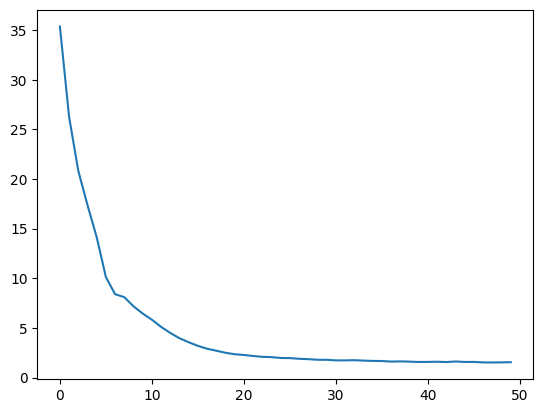

In [12]:
sgmodel = SkipGramNegativeSampling(n_nodes=len(G), dim=16)
epoch_loss = []
opt = Adam(sgmodel.parameters(), lr=0.1)
dloader = DataLoader(dataset, batch_size=len(G))
for epoch in trange(50):
    for start_nodes, pos_context, neg_context in dloader:
        loss = sgmodel(start_nodes, pos_context, neg_context).sum(dim=1).mean()
        opt.zero_grad()
        loss.backward()
        opt.step()
    epoch_loss.append(loss.item())
plt.plot(epoch_loss);

We evaluate the model by mutual information between ground truth labels and cluster indices.

In [13]:
with torch.no_grad():
    emb = sgmodel.start_node_emb(torch.arange(len(G)))
_, pred_labels, _ = k_means(emb, n_clusters=8)
mi = mutual_info_score(labels, pred_labels)
assert mi > 0.15

Let us plot the t-SNE visualization of node embeddings.

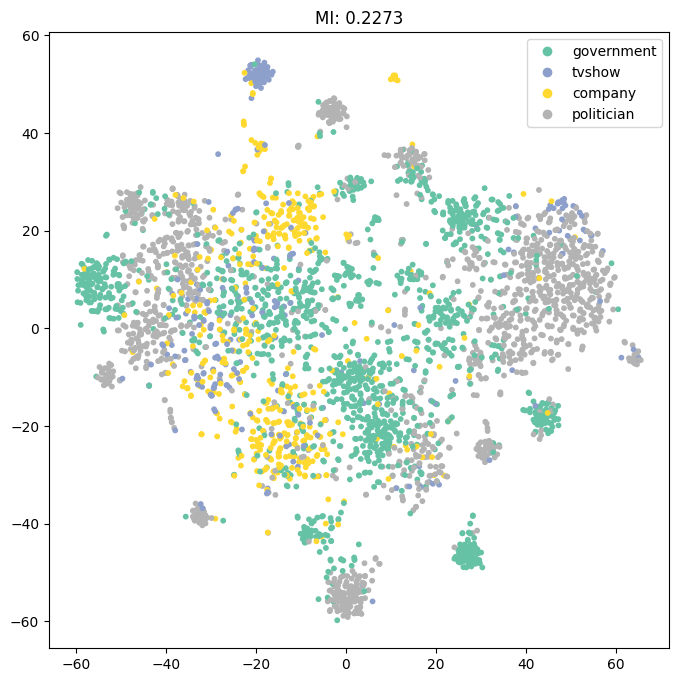

In [14]:
decomposition = TSNE(n_components=2)
xy_emb = decomposition.fit_transform(emb)

plt.figure(figsize=(8, 8))
scatter = plt.scatter(xy_emb[:, 0], xy_emb[:, 1], c=labels, s=10, cmap=plt.cm.Set2)

plt.legend(handles=scatter.legend_elements()[0], labels=unique)
plt.title(f'MI: {mi:.4f}');

### Task 2. Node2Vec (0 points)

In this task, we will consider Node2Vec embedding algorithm. In Node2Vec, we learn a mapping of nodes to a low-dimensional space of features that maximizes the likelihood of preserving network neighborhoods of nodes. It is similar to DeepWalk, but uses *biased random walk procedure* which efficiently explores diverse neighborhoods. There are two parameters:

* Return parameter $p$ controls the likelihood of immediately revisiting a node in the walk. Setting it to a high value ensures that we are less likely to sample an already-visited node in the following two steps.

* In-out parameter $q$ allows the search to differentiate between “inward” and “outward” nodes. If $q > 1$, the random walk is biased towards nodes close to previous node. In contrast, if $q < 1$, the walk is more inclined to visit nodes which are further away from the previous node.

<img src='https://raw.githubusercontent.com/netspractice/network-science/main/images/biased_random_walk.png' width=300>

Consider that we just moved from the node $t$ to $v$ and now we want to decide on the next step so it evaluates the transition probabilities on edges ($v$, $x$) leading from $v$. Then the *unnormalized* probability is

$$\alpha = \begin{cases}
\frac{1}{p} &  \text{ if } d_{tx} = 0\\
1 & \text{ if } d_{tx} = 1\\
\frac{1}{q} & \text{ if } d_{tx} = 2\\
\end{cases}$$

where $d_{tx}$ is the shortest path distance between nodes $t$ and $x$. To compute the true probability, we need to normalize values so that the sum is 1.

Write a function `biased_random_walk` that takes a graph, node for which we start random walk, length of walk, parameters `p` and `q` and returns a list with random walks.

*Hint: do not use `nx.shortest_path` to calcule shortest paths, it is too expensive. Look at the image above — we can explicitly calculate probabilities for all neighbors of $v$ using neighborhood of $t$*.

In [15]:
def biased_random_walk(G, node, length, p, q):
    # YOUR CODE HERE
    #raise NotImplementedError()
    walk = [node]
    previos_node = None
    previous_node_neighbors = []
    for i in range(length - 1):
      cur_node = walk[-1]
      cur_node_neighbours = np.array(list(G.neighbors(cur_node)))
      probability = np.array([1/q] * len(cur_node_neighbours), dtype=float)
      probability[cur_node_neighbours == previos_node] = 1/p
      probability[np.isin(cur_node_neighbours, previous_node_neighbors)] = 1

      probability = probability / sum(probability)
      next_node = np.random.choice(cur_node_neighbours, p=probability)

      walk.append(next_node)
      previos_node = cur_node
      previous_node_neighbors = cur_node_neighbours
    return walk

In [16]:
rwalks = biased_random_walk(G, 0, 10, 0.1, 0.5)
assert len(rwalks) == 10
rwalks = biased_random_walk(G, node=0, length=4, p=0.001, q=1000)
assert rwalks[0] == rwalks[2]
assert rwalks[1] == rwalks[3]
rwalks = biased_random_walk(G, node=0, length=4, p=1000, q=0.001)
assert len(set(rwalks)) >= 3

Let us generate biased random walks.

In [17]:
def sample_biased_random_walks(G, walks_per_node, length, p, q):
    walks = []
    for node in tqdm(G.nodes, leave=False, desc='Sampling biased random walks'):
        for _ in range(walks_per_node):
            walk_from_node = biased_random_walk(G, node, length, p, q)
            walks.append(walk_from_node)
    return np.array(walks)

In [18]:
walks_per_node = 5
length = 5
rwalks = sample_biased_random_walks(G, walks_per_node, length, p=0.25, q=0.25)
rwalks

Sampling biased random walks:   0%|          | 0/3873 [00:00<?, ?it/s]

array([[   0,    1,   59,  175,    6],
       [   0,   47,   29,  222,  411],
       [   0,   42,  162,   34,    8],
       ...,
       [3872, 1495,  529,   51,    1],
       [3872, 1980, 3872, 1980, 3177],
       [3872, 1495, 3177,  409,  408]])

Train the model.

  0%|          | 0/50 [00:00<?, ?it/s]

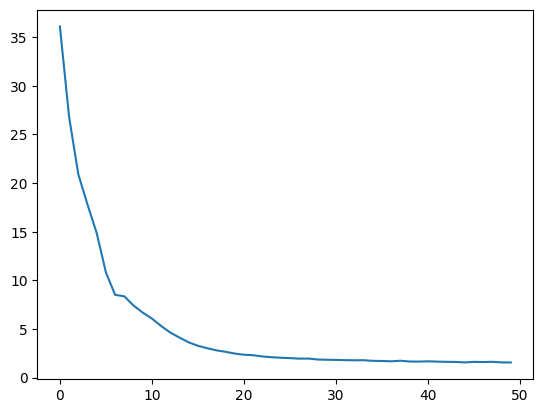

In [19]:
e_loss = []
dataset = NodeContextDataset(rwalks, len(G), n_neg=5)
dloader = DataLoader(dataset, batch_size=len(G))
sgmodel = SkipGramNegativeSampling(n_nodes=len(G), dim=16)
opt = Adam(sgmodel.parameters(), lr=0.1)
for e in trange(50):
    for start_nodes, pos_context, neg_context in dloader:
        loss = sgmodel(start_nodes, pos_context, neg_context).sum(dim=1).mean()
        opt.zero_grad()
        loss.backward()
        opt.step()
    e_loss.append(loss.item())
plt.plot(e_loss);

In [20]:
with torch.no_grad():
    emb = sgmodel.start_node_emb(torch.arange(len(G)))
_, pred_labels, _ = k_means(emb, n_clusters=8)
mi = mutual_info_score(labels, pred_labels)
assert mi > 0.15

Plot t-SNE visualization of node embeddings.

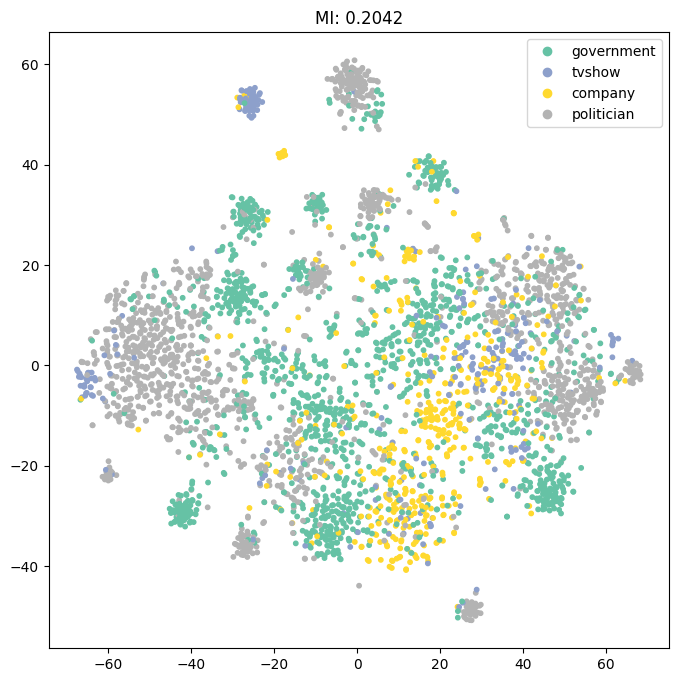

In [21]:
decomposition = TSNE(n_components=2)
xy_emb = decomposition.fit_transform(emb)

plt.figure(figsize=(8, 8))
scatter = plt.scatter(xy_emb[:, 0], xy_emb[:, 1], c=labels, s=10, cmap=plt.cm.Set2)

plt.legend(handles=scatter.legend_elements()[0], labels=unique)
plt.title(f'MI: {mi:.4f}');

### Task 3. GraRep (3 points)

The idea behind GraRep is to account for multiscale relationships between nodes. For example,a student can have 1-hop neighborhood of friends, 2-hop neighborhood of classmates, 3-hop neighborhood of society and so on.

<img src="https://raw.githubusercontent.com/netspractice/network-science/main/images/multiscale_relationships.png" width=350>

Unlike DeepWalk, GraRep defines different objective functions for capturing the different $k$-step local relational information by manipulating transition matrices in the $k$-th powers defined over the graph. Recall that the transition matrix is $P = D^{-1}A$ where $D$ is a degree matrix. $P_{ij}$ refers to a probability to move from the node $i$ to the node $j$ in one step of a random walk. Therefore, $P^k_{ij}$ is a probability to move from the node $i$ to the node $j$ in $k$ steps of a random walk.

Write a function `csr_transition_matrix` that takes a graph and returns a transition matrix. To save memory and speed up the following calculation of powers, convert transition matrix to sparse format by `scipy.sparse.csr_matrix`.

In [22]:
def csr_transition_matrix(G):
    # YOUR CODE HERE
    n = len(G)

    adj = nx.to_scipy_sparse_array(G, nodelist=sorted(G.nodes()))
    row_sums = np.array(adj.sum(axis=1)).flatten()

    row_sums[row_sums == 0] = 1

    inv_row_sums = csr_matrix((1 / row_sums, (np.arange(n), np.arange(n))), shape=(n, n))

    transition = inv_row_sums @ adj

    return transition

In [23]:
P = csr_transition_matrix(G)
assert type(P) == csr_matrix
assert P.shape == (len(G), len(G))
assert round(P[3, 9], 4) == 0.0417

Similar to DeepWalk, there are two types of embeddings:
* $v_i$ is a vector that represents the start node $i$
* $u_j$ is a vector that represents the context node $j$

Our objective aims to maximize: 1) the probability that these pairs come from the graph, and 2) the probability that all other pairs do not come from the graph (negative samples). The objective function for nodes $i, j$ in the transition matrix of the power $k$ is

$$\mathcal L^k_{ij} = P^k_{ij}\log \sigma(v_i^\top u_j) + \frac{\lambda}{|V|}\sum_{t=1}^{|V|}P^k_{tj}\log \sigma(-v_t^\top u_j)$$

where $\lambda$ is the hyperparameter indicating the number of negative samples. Optimizing this objective makes observed pairs $(i, j)$ have similar embeddings, while scattering unobserved pairs $(t, j)$. Substitution $v_i^\top u_j = X_{ij}$ and setting $\frac{\partial \mathcal L_{ij}}{ \partial X_{ij}} = 0$ yields

$$v_i^\top u_j = X_{ij}^k = \log \frac{P^k_{ij}}{\sum_{t=1}^{|V|}P^k_{tj}} - \log\frac{\lambda}{|V|}$$

Let us call $X^k$ log probabilistic matrix. Write a function `log_probabilistic_matrix` that takes a transition matrix, hyperparameter $\lambda$ and returns a log probabilistic matrix.

_Remark: to prevent $-\infty$ in log, add $\varepsilon=1^{-6}$ as follows `np.log(x + 1e-6)`_

In [24]:
def log_probabilistic_matrix(P, lambd):
    # YOUR CODE HERE
    P = P.toarray()

    V = P.shape[0]
    epsilon = 1e-6

    col_sums = P.sum(axis=0)
    col_sums[col_sums == 0] = 1
    normalized = P / col_sums

    log_left = np.log(normalized + epsilon)

    log_right = np.log(lambd / V + epsilon)

    res = log_left - log_right

    return np.matrix(res)


In [25]:
X = log_probabilistic_matrix(P, lambd=5)
assert type(X) == np.matrix
assert X.shape == (len(G), len(G))
assert round(X[3, 9], 4) == 3.182

The log probabilistic matrix $X^k$ can be approximated by truncated SVD so that

$$X^k \approx X_d^k = U_d^k \Sigma_d^k (V_d^k)^\top$$

where $d$ is the number of singular values of truncated SVD. Thus, embeddings of start nodes can be obtained by

$$v_i = \left[U_d^k \sqrt{\Sigma_d^k}\right]_i$$

and embeddings of context nodes by

$$u_j = \left[\sqrt{\Sigma_d^k} (V_d^k)^\top\right]_j$$

_Remark: the power 1/2 makes SVD symmetric. It is empirically shown that the symmetric SVD is better for social graphs and makes embeddings more "similar" to corresponding embeddings of SkipGram with negative sampling in a sence of some matrix properties._

Write a function `svd_emb` that takes a log probabilistic matrix, number of dimensions (number of largest singular values) in truncated SVD and returns embeddings of start nodes.

_Hint: use `scipy.sparse.linalg.svds` to calculate truncated SVD for a given number of singular values._

In [26]:
from scipy.sparse.linalg import svds
def svd_emb(X, dim):
    # YOUR CODE HERE
    U, s, Vt = svds(X, k=dim, return_singular_vectors=True)

    U = U[:, ::-1]
    s = s[::-1]
    Vt = Vt[::-1, :]

    return U

In [27]:
_emb = svd_emb(X, dim=4)
assert type(_emb) == np.ndarray
assert _emb.shape == (3873, 4)


The resulting node embeddings are concatenated from the log probabilistic matrices $X, X^2, ..., X^k$.

In `grarep_emb`, we calculate powers of transition matrix $P, P^2, \dots, P^k$, calculate and concatenate embeddings of start nodes, then we compress them to the original number of dimensions by PCA.

In [28]:
def grarep_emb(G, dim, k, lambd):
    emb = []
    P_1 = csr_transition_matrix(G)
    P = P_1.copy()
    for i in trange(k):
        X = log_probabilistic_matrix(P, lambd=lambd)
        _emb = svd_emb(X, dim=dim)
        emb.append(_emb)
        if i == (k - 1):
            continue
        P = P @ P_1
    emb = PCA(n_components=dim).fit_transform(np.concatenate(emb, axis=1))
    return emb

Finally, we evaluate the model by mutual information between ground truth labels and cluster indices.

In [29]:
emb = grarep_emb(G, dim=16, k=4, lambd=5)
assert emb.shape == (len(G), 16)
_, pred_labels, _ = k_means(emb, n_clusters=8)
mi = mutual_info_score(labels, pred_labels)
assert mi > 0.22

  0%|          | 0/4 [00:00<?, ?it/s]

Plot t-SNE visualization of node embeddings.

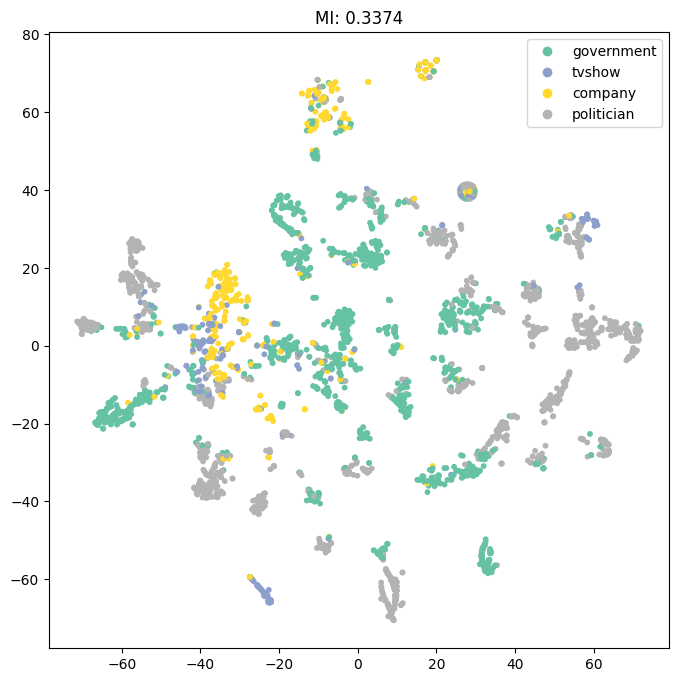

In [30]:
decomposition = TSNE(n_components=2)
xy_emb = decomposition.fit_transform(emb)

plt.figure(figsize=(8, 8))
scatter = plt.scatter(xy_emb[:, 0], xy_emb[:, 1], c=labels, s=10, cmap=plt.cm.Set2)
plt.legend(handles=scatter.legend_elements()[0], labels=unique)
plt.title(f'MI: {mi:.4f}');

### CORA dataset

In [31]:
import torch.nn.functional as F
from zlib import adler32
from tqdm.notebook import tqdm, trange
import numpy as np
from sklearn.metrics import balanced_accuracy_score
import pandas as pd
import requests
from tqdm.notebook import trange
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
import torch.nn as nn
from torch.optim import Adam
import matplotlib.pyplot as plt
import torch

In [32]:
!pip install  dgl -f https://data.dgl.ai/wheels/torch-2.4/repo.html

Looking in links: https://data.dgl.ai/wheels/torch-2.4/repo.html


In [33]:
import dgl
from dgl.data import CoraGraphDataset
from dgl import function as fn
from dgl.nn import SAGEConv

In [34]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

The Cora dataset consists of 2708 scientific publications classified into one of seven classes. The citation network consists of 10556/2 links. Let us take a closer look at this dataset. Each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary. The dictionary consists of 1433 unique words.

In [35]:
data = CoraGraphDataset(force_reload=True)

Finished data loading and preprocessing.
  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done saving data into cached files.


In [36]:
graph = data[0]
graph

Graph(num_nodes=2708, num_edges=10556,
      ndata_schemes={'train_mask': Scheme(shape=(), dtype=torch.bool), 'val_mask': Scheme(shape=(), dtype=torch.bool), 'test_mask': Scheme(shape=(), dtype=torch.bool), 'label': Scheme(shape=(), dtype=torch.int64), 'feat': Scheme(shape=(1433,), dtype=torch.float32)}
      edata_schemes={})

Adjacency matrix can be obtained as follows

In [37]:
adj = graph.adj().to_dense()
adj

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 1., 0.]])

Feature matrix is stored in node features `feat`.

In [38]:
feat = graph.ndata['feat']
print(feat.shape)
feat

torch.Size([2708, 1433])


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In DGL, Cora feature matrix are normalized so that the sum per row is 1. Labels are represent type of the publication, they are stored in `label`.

In [39]:
label = graph.ndata['label']
label

tensor([3, 4, 4,  ..., 3, 3, 3])

Here are train, validation and test masks.

In [40]:
train_mask = graph.ndata['train_mask']
val_mask = graph.ndata['val_mask']
test_mask = graph.ndata['test_mask']
val_mask, train_mask, test_mask

(tensor([False, False, False,  ..., False, False, False]),
 tensor([ True,  True,  True,  ..., False, False, False]),
 tensor([False, False, False,  ...,  True,  True,  True]))

### Task 4. Graph convolution as matrix product (0 points)

Graph convolutional network (GCN) was proposed in [[1]](#references) and defined on an undirected graph as the following propagation rule:

$$H^{(l)}=\sigma\left(\tilde D^{-1 / 2} \tilde A \tilde D^{-1 / 2} H^{(l-1)} W^{(l)}\right)$$

where $\tilde A = A + I_N$ is the adjacency matrix with added self-connections. $I_N$ is the identity matrix, $\tilde D_{ii} = \sum_j \tilde A_{ij}$ is the degree matrix and $W^{(l)}$ is trainable matrix at the layer $l$. $\sigma$ represents non-linear activation function such as ReLU. $H^{(l)}$ is the hidden states at the layer $l$ and $H^{(0)} = X$ is the initial feature matrix.

Write a class `GCNMatrixProductLayer` that takes adjacency matrix, hidden states and returns the next hidden states before activation.

In [41]:
class GCNMatrixProductLayer(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.dense = nn.Linear(in_dim, out_dim)

    def forward(self, adj, h):
        _adj = adj.clone()
        # YOUR CODE HERE
        #raise NotImplementedError()
        _adj = _adj + np.eye(adj.shape[0], dtype='float32')
        norm = _adj.sum(dim=0) ** (-0.5)
        _adj = norm[:, None] * _adj * norm[None, :]
        h = self.dense(h)
        return _adj @ h

In [42]:
layer = GCNMatrixProductLayer(in_dim=2708, out_dim=10)
with torch.no_grad():
    layer.dense.weight.fill_(0.1)
    layer.dense.bias.fill_(0.1)
    h = layer(adj, torch.eye(2708))
assert round(h[0, 0].item(), 2) == 0.19

/tmp/ipython-input-3417157158.py:10: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  _adj = _adj + np.eye(adj.shape[0], dtype='float32')


Write a class `GCNMatrixProduct` that takes the adjacency matrix and feature matrix and performs two-layer convolution with intermediate ReLU activation. The class initialized by input, hidden and output dimensions.

In [43]:
class GCNMatrixProduct(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim):
        super().__init__()
        # YOUR CODE HERE
        #raise NotImplementedError()
        self.conv1 = GCNMatrixProductLayer(in_dim=in_dim, out_dim=hid_dim)
        self.conv2 = GCNMatrixProductLayer(in_dim=hid_dim, out_dim=out_dim)

    def forward(self, adj, feat):
        # YOUR CODE HERE
        #raise NotImplementedError()
        h = self.conv1(adj, feat)
        h = F.relu(h)
        h = self.conv2(adj, h)
        return h

In [44]:
model = GCNMatrixProduct(2708, 32, 7)
logits = model(adj, torch.eye(2708))
assert logits.shape == (2708, 7)
assert logits.min() < 0

/tmp/ipython-input-3417157158.py:10: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  _adj = _adj + np.eye(adj.shape[0], dtype='float32')


Let us create the two-layer GCN for node classification task.

In [45]:
model = GCNMatrixProduct(1433, 32, 7)
opt = torch.optim.Adam(model.parameters(), lr=0.01)
log = []

We train the model in semi-supervised setting: propagate information over the full graph, but optimize it by only train cross-entropy loss.

  0%|          | 0/200 [00:00<?, ?it/s]

/tmp/ipython-input-3417157158.py:10: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  _adj = _adj + np.eye(adj.shape[0], dtype='float32')


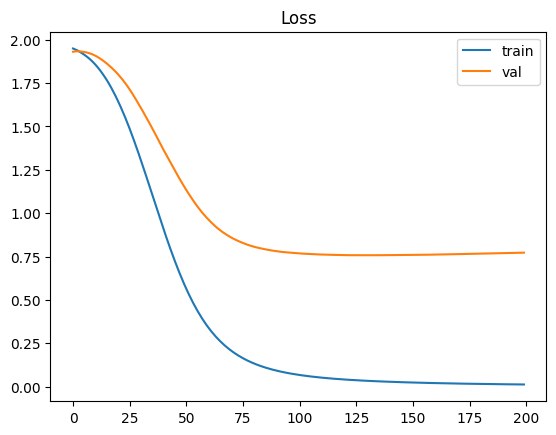

In [46]:
n_epochs = 200
for i in trange(n_epochs):

    logits = model(adj, feat)
    train_loss = F.cross_entropy(logits[train_mask], label[train_mask])

    opt.zero_grad()
    train_loss.backward()
    opt.step()

    with torch.no_grad():
        val_loss = F.cross_entropy(logits[val_mask], label[val_mask])

    log.append([train_loss.item(), val_loss.item()])

plt.plot(np.array(log))
plt.title('Loss')
plt.legend(['train', 'val'])
plt.show()

We evaluate the model by balanced accuracy that accounts for inbalanced classes.

In [47]:
with torch.no_grad():
    logits = model(adj, feat)
y_pred = torch.argmax(logits[test_mask], 1)
score = balanced_accuracy_score(label[test_mask], y_pred)
assert score > 0.7
print(f'Balanced accuracy: {score:.2f}')

Balanced accuracy: 0.80


/tmp/ipython-input-3417157158.py:10: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  _adj = _adj + np.eye(adj.shape[0], dtype='float32')


### Task 5. Graph convolution as message passing (0 points)

The original GCN is computationally expensive for large graphs since it requires to compute matrix product $\tilde D^{-1 / 2} \tilde A \tilde D^{-1 / 2} H^{l}$, that costs $O(|V|^2)$. However, the information is propagated along edges, the number of which is linearly depends on the number of nodes in scale-free networks, that is $O(|V|)$. Message passing framework was proposed in [[2]](#references) to reduce computation costs by representing a graph neural network's layer as the composition of two functions:

$$m_{ij}^l = \text{Message}\left(h_i^{l-1}, h_j^{l-1}\right)$$
$$h_i^l = \text{Reduce}_{j \in \mathcal{N}_\text{in}(i)}\left(m_{ji}^l\right)$$

where $\text{Message}(\cdot)$ is the message function that applied on each edges in the graph and stores computed values (messages) on edges. $\text{Reduce}_{j \in \mathcal{N}_\text{in}(i)}(\cdot)$ is the reduce (aka aggregation, reduction) function that applied on each node and aggregates messages from incoming links (mailboxes).

<img src='https://raw.githubusercontent.com/netspractice/network-science/main/images/messpass.png' width=600>

In particular, GCN can be represented as follows:

$$h_i^l = \sigma \left(W^l \sum_{j \in \mathcal{N}_\text{in}(i)}\frac{h_j^{l-1}}{\sqrt{|\mathcal{N}_\text{in}(j)||\mathcal{N}_\text{in}(i)|}}\right)$$

where the message function

$$m_{ji}^l = \frac{W^l h_j^{l-1}}{\sqrt{|\mathcal{N}_\text{in}(j)|}}$$

is the transformed source node's hidden state normalized by the in-degree of the source node. The reduce function

$$h_i^l = \sigma \left(\frac{\sum_{j \in \mathcal{N}_\text{in}(i)} m_{ji}^l}{\sqrt{|\mathcal{N}_\text{in}(i)|}}\right)$$

is the sum over all incoming neighbors' hidden states with in-degree normalization and subsequent activation $\sigma$. Here we assume that the graph includes self-connections, that is a node is in its neighborhood. We also assume that the graph is equivalent to its undirected representation, that is $A = A^\top$.

In DGL, message passing is applied by `graph.update_all(message_func, reduce_func)` where `message_func` is defined on edges and `reduce_func` on nodes. DGL contains built-in message and reduce functions, but it is also possible to define your own functions. GCN can be implemented using following functions:
* message function `fn.copy_u(u='h', out='m')` copies the source node feature `h` into the mailbox `m`
* reduce function `fn.sum(msg='m', out='h')` sums messages from mailboxes `m` and save the result into the node feature `h`

Write a class `GCNMessagePassingLayer` that takes a graph, hidden states and returns the next hidden states before activation.

*Hints:*
* _adding node features is similar to adding values to a dictionary: `graph.ndata['h'] = h`_
* _in-degrees can be computed by `graph.in_degrees()`_

*Remark: `graph.local_scope()` makes all operations isolated from the original graphs.*

In [48]:
class GCNMessagePassingLayer(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.dense = nn.Linear(in_dim, out_dim)
    def forward(self, graph, h):
        with graph.local_scope():
            graph = graph.add_self_loop()
            # YOUR CODE HERE
            #raise NotImplementedError()
            norm = graph.in_degrees()[:,None]**(-0.5)

            h = self.dense(h)

            h = h * norm

            graph.ndata['h'] = h

            graph.update_all(fn.copy_u(u='h', out='m'),
                             fn.sum(msg='m', out='h'))
            h = graph.ndata['h']

            h = h * norm
            return h

In [49]:
layer = GCNMessagePassingLayer(in_dim=2708, out_dim=10)
with torch.no_grad():
    layer.dense.weight.fill_(0.1)
    layer.dense.bias.fill_(0.1)
    h = layer(graph, torch.eye(2708))
assert round(h[0, 0].item(), 2) == 0.19

Write a class `GCNMessagePassing` that takes the graph and feature matrix and performs two-layer convolution with intermediate ReLU activation. The class initialized by input, hidden and output dimensions.

In [50]:
class GCNMessagePassing(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim):
        super().__init__()
        # YOUR CODE HERE
        #raise NotImplementedError()
        self.conv1 = GCNMessagePassingLayer(in_dim=in_dim, out_dim=hid_dim)
        self.conv2 = GCNMessagePassingLayer(in_dim=hid_dim, out_dim=out_dim)

    def forward(self, graph, feat):
        # YOUR CODE HERE
        #raise NotImplementedError()
        h = self.conv1(graph, feat)
        h = F.relu(h)
        h = self.conv2(graph, h)
        return h

In [51]:
model = GCNMessagePassing(2708, 32, 7)
logits = model(graph, torch.eye(2708))
assert logits.shape == (2708, 7)
assert logits.min() < 0

In [52]:
model = GCNMessagePassing(in_dim=1433, hid_dim=32, out_dim=7)
opt = Adam(model.parameters(), lr=0.01)
log = []

We train the model in semi-supervised setting: propagate information over the full graph, but optimize it by only train cross-entropy loss.

  0%|          | 0/200 [00:00<?, ?it/s]

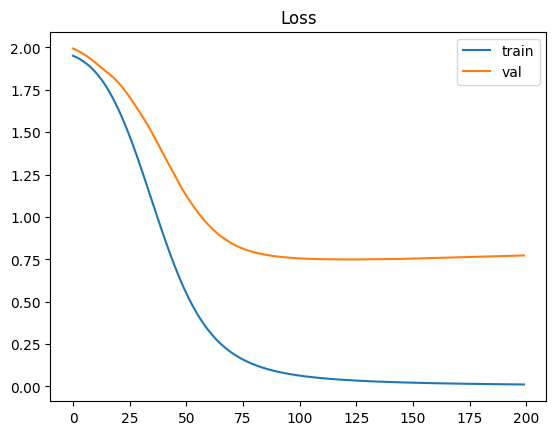

In [53]:
n_epochs = 200
for i in trange(n_epochs):

    logits = model(graph, feat)
    train_loss = F.cross_entropy(logits[train_mask], label[train_mask])

    opt.zero_grad()
    train_loss.backward()
    opt.step()

    with torch.no_grad():
        val_loss = F.cross_entropy(logits[val_mask], label[val_mask])

    log.append([train_loss.item(), val_loss.item()])

plt.plot(np.array(log))
plt.title('Loss')
plt.legend(['train', 'val'])
plt.show()

In [54]:
with torch.no_grad():
    logits = model(graph, feat)
y_pred = torch.argmax(logits[test_mask], 1)
score = balanced_accuracy_score(label[test_mask], y_pred)
assert score > 0.7
print(f'Balanced accuracy: {score:.2f}')

Balanced accuracy: 0.81


### Task 6. Graph auto-encoder (4 points)

Graph auto-encoder (GAE) was proposed in [[3]](#references) as a simple node embedding model that incorporates node features. The model is consists of two parts:
* GCN node encoder $Z = \text{GCN}(X, A)$ where $X$ is the feature matrix
* Dot product decoder $\hat A = \sigma(ZZ^\top)$ where $\sigma$ is the sigmoid function

Write a class `DotProductDecoder` that takes node embeddgins and returns dot product before activation.

In [55]:
class DotProductDecoder(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, z):
        # YOUR CODE HERE
        # return np.dot(z, z.T)
        return z @ z.T

In [56]:
decoder = DotProductDecoder()
assert torch.all(decoder(torch.eye(2)[:, :1]) * 2 == torch.tensor([[2, 0], [0, 0]]))

The GAE is trained to reconstruct the adjacency matrix, that is the decoder can be considered as the link prediction model. The reconstruction loss is the binary cross entropy between the adjacency matrix $A$ and reconstructed adjacency matrix $\hat A$. To overcome the imbalance between positive and negative edges, the loss is computed with positive weights — the number of negative exaples divided by the number of positive examples, that is $(|V|^2 - E)/E$.

Write a class `ReconstructionLoss` that takes reconstructed adjacency matrix and computes the binary cross entropy with positive weights `F.binary_cross_entropy_with_logits(input, target, pos_weight=...)`. The class is initialized by the adjacency matrix.

In [57]:
class ReconstructionLoss:
    def __init__(self, adj):
        # YOUR CODE HERE
        self.adj = adj
        V = adj.size(0)
        E = adj.sum().item()
        self.pos_weight = torch.tensor((V ** 2 - E) / E)

    def __call__(self, rec_adj):
        # YOUR CODE HERE
        return F.binary_cross_entropy_with_logits(rec_adj, self.adj, pos_weight=self.pos_weight)

In [58]:
rec_loss = ReconstructionLoss(torch.eye(2))
assert round(rec_loss(1 - torch.eye(2)).item(), 4) == 1.0032

Here we initialize encoder, decoder, reconstruction loss and optimizer.

In [59]:
encoder = GCNMessagePassing(in_dim=1433, hid_dim=64, out_dim=32)
decoder = DotProductDecoder()
rec_loss = ReconstructionLoss(adj)
opt = Adam(encoder.parameters(), lr=0.02)
log = []

Complete the training loop for GAE. Train the model in unsupervised setting: calculate the reconstruction loss over all edges.

  0%|          | 0/400 [00:00<?, ?it/s]

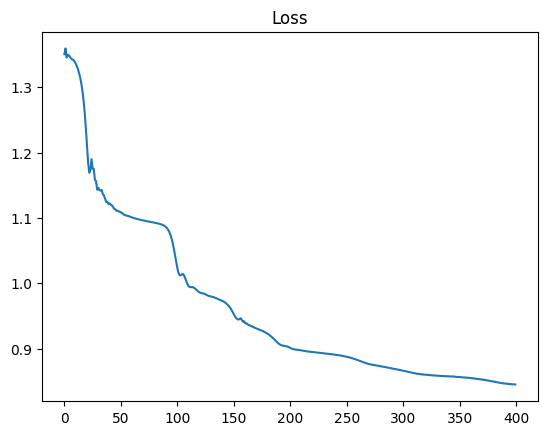

In [60]:
n_epochs = 400

for i in trange(n_epochs):
    # YOUR CODE HERE
    opt.zero_grad()

    z = encoder(graph, feat)

    rec_adj = decoder(z)

    loss = rec_loss(rec_adj)

    loss.backward()
    opt.step()

    log.append(loss.item())
    # print(loss.item())

plt.plot(np.array(log))
plt.title('Loss')
plt.show()

We evaluate GAE by obtaining node embeddings via GCN encoder and training the logistic regression for node classification task.

In [61]:
with torch.no_grad():
    X = encoder.forward(graph, feat).numpy()
y = label.numpy()

lr = LogisticRegression()
lr.fit(X[train_mask], y[train_mask])

y_true = y[test_mask]
y_pred = lr.predict(X[test_mask])
score = balanced_accuracy_score(y_true, y_pred)
assert score >= 0.6
print(f'Balanced accuracy: {score:.2f}')

Balanced accuracy: 0.73


Let us visualize node embeddings via t-SNE.

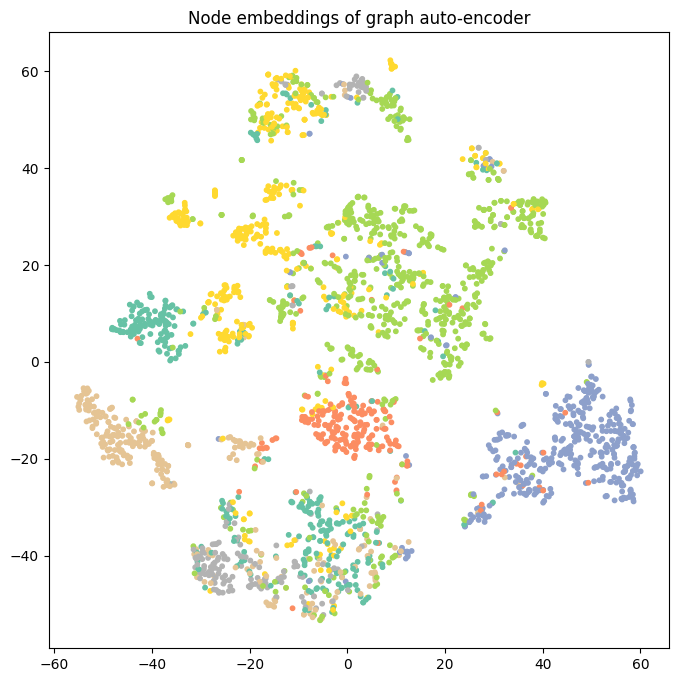

In [62]:
xy_emb = TSNE(n_components=2).fit_transform(X)
plt.figure(figsize=(8, 8))
plt.title('Node embeddings of graph auto-encoder')
scatter = plt.scatter(xy_emb[:, 0], xy_emb[:, 1], c=label, s=10, cmap=plt.cm.Set2)

Note that GAE is the simplest encoder-decoder graph model that can be extended to the variational graph auto-encoder (VGAE) [[3]](#references) and GraphVAE [[4]](#references).

### Task 4. Graph attention network (4 points)

The graph attention network (GAT) was proposed in [[5]](#references). The idea behind GAT is based on the multi-head self-attention mechanism [[6]](#references). The graph attention layer is defined by message passing as follows:

$$h_i^{l} = \sum_{j \in \mathcal{N}(i)}\alpha_{ij}^{l}W_\text{node}^{l}h_j^{l-1}$$

where $\alpha_{ij}$ is the attention score defined on each edge:

$$\alpha_{ij}^{l} = \text{Softmax}_i(e_{ij}^{l})$$

where $e_{ij}^{l}$ is the edge hidden state obtained by the linear transformation of concatenatenated nodes' hidden states and subsequent LeakyReLU activation:

$$e_{ij}^{l} = \text{LeakyReLU}(W_\text{edge}^l[W_\text{node}^{l}h_i^{l-1}||W_\text{node}^{l}h_j^{l-1}])$$

where $[\cdot||\cdot]$ is concatenation. The multi-head self-attention is defined by different types of attention score (heads) $(\alpha_{ij}^{l})_0, (\alpha_{ij}^{l})_1, ..., (\alpha_{ij}^{l})_N,$. The final node's hidden state is obtained by concatenation all heads' outputs.

Here is the GAT layer that calculates nodes' preliminary hidden states by `self.fc` ($W_\text{node}$) layer and copies them to the node feature `z`, then concatenates them on edges by `edge_cat` function and copies to the edge feature `z`, then calculates attention score by `self.attn_fc` ($W_\text{edge}$) layer and performs message passing. At the end, it concatenates the next hidden states from all heads.

_Remark: `graph.apply_edges` applies an edge-wise function on all edges in the graph._

In [63]:
class GATLayer(nn.Module):
    def __init__(self, in_dim, out_dim, n_heads):
        super().__init__()
        self.fc = nn.Linear(in_dim, out_dim)
        self.n_heads = n_heads
        attn_fc = []
        for _ in range(n_heads):
            attn_fc.append(nn.Linear(2 * out_dim, 1))
        self.attn_fc = nn.ModuleList(attn_fc)

    def forward(self, graph, feat):
        with graph.local_scope():
            graph = graph.add_self_loop()
            graph.ndata['z'] = self.fc(feat)
            graph.apply_edges(edge_cat)
            edge_z = graph.edata['z']
            h = []
            for i in range(self.n_heads):
                graph.edata['e'] = F.leaky_relu(self.attn_fc[i](edge_z))
                graph.update_all(message_func, reduce_func)
                h.append(graph.ndata['h'])
            return torch.cat(h, dim=1)

In DGL, we can implement specific functions that can be applied on edges or nodes. Let us define an edge-wise function that concatenates nodes' preliminary hidden states `z` and copies them to the edge feature `z`. It takes a batch of edges `dgl.udf.EdgeBatch` which contains source node features in the attribute `src`, destination node features in the attribute `dst` and edge features in the attribute `data`. For example:
* `edges.src['z']` is the source node feature `z`
* `edges.dst['z']` is the destination node feature `z`
* `edges.data['e']` is the edges feature `e`

Write a function `edge_cat` that takes a batch of edges and returns a dictionary where the key is `z` and the value is concatenated the source node feature `z` and the destination node feature `z`.

In [64]:
def edge_cat(edges):
    # YOUR CODE HERE
    src_z = edges.src['z']
    dst_z = edges.dst['z']

    val = torch.cat([src_z, dst_z], dim=1)

    return {'z': val}

In [65]:
class EdgeBatch:
    def __init__(self):
        self.src = {'z': torch.arange(10).tile(3, 1)}
        self.dst = {'z': torch.arange(10, 20).tile(3, 1)}
        self.data = {'e': torch.arange(20).tile(5, 1)}
edges = EdgeBatch()
res = edge_cat(edges)
assert res['z'].shape == (3, 20)
assert torch.all(res['z'][0] == torch.arange(20))

Next, implement the message function. Message function simply copies the source nodes' feature `z` and edges' feature `e` into mailboxes `z` and `e`.

Write a function `message_func` that takes a batch of edges and returns a dictionary:
* the key is `z`, the value is source nodes' feature `z`
* the key is `e`, the value is edges' feature `e`

In [66]:
def message_func(edges):
    # YOUR CODE HERE
    return {'z': edges.src['z'], 'e': edges.data['e']}

In [67]:
class EdgeBatch:
    def __init__(self):
        self.src = {'z': torch.arange(10).tile(3, 1)}
        self.dst = {'z': torch.arange(10, 20).tile(3, 1)}
        self.data = {'e': torch.arange(20).tile(5, 1)}
edges = EdgeBatch()
res = message_func(edges)
assert res['z'].shape == (3, 10)
assert torch.all(res['z'][0] == torch.arange(10))
assert res['e'].shape == (5, 20)
assert torch.all(res['e'][0] == torch.arange(20))

The reduce funtion takes a batch of nodes `dgl.udf.NodeBatch` and calculates the next hidden states of nodes by summation of preliminary hidden states `z` weighted by attention score:
$$\alpha_{ij} = \text{Softmax}_i(e_{ij})$$
$$h_i = \sum_{j \in \mathcal{N}(i)}\alpha_{ij}z_j$$

The batch of nodes contains incoming messages in the attribute `mailbox` of the shape (N, D, 1), where N is the number of nodes in the batch, D is the number of messages received per node for this node batch.

Write a function `reduce_func` that takes a batch of nodes with mailboxes `z` and `e` and returns a dictionary where the key is `h`, the value is the next hidden states of nodes.

In [68]:
def reduce_func(nodes):
    # YOUR CODE HERE
    a = F.softmax(nodes.mailbox['e'], dim=1)
    h = torch.sum(a * nodes.mailbox['z'], dim=1)
    return {'h': h}

In [69]:
class NodeBatch:
    def __init__(self):
        self.mailbox = dict()
        self.mailbox['e'] = torch.arange(10, 20, dtype=float).tile(3, 1)[..., None]
        self.mailbox['z'] = torch.arange(10, dtype=float).tile(3, 1)[..., None]
nodes = NodeBatch()
assert reduce_func(nodes)['h'].shape == (3, 1)
assert round(reduce_func(nodes)['h'][0].item(), 4) == 8.4185

Write a class `GAT` that takes a graph and a feature matrix and performs two-layer convolution with intermediate ReLU activation. The class initialized by input, hidden, output dimensions and the number of heads in the first layer. The second layer contains a single head.

In [70]:
class GAT(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, n_heads):
        super().__init__()
        # YOUR CODE HERE
        self.conv1 = SAGEConv(in_dim, hid_dim * n_heads, activation=F.relu, aggregator_type='mean')

        self.conv2 = SAGEConv(hid_dim * n_heads, out_dim, aggregator_type='mean', activation=None)

    def forward(self, graph, feat):
        # YOUR CODE HERE
        h = self.conv1(graph, feat)

        h = self.conv2(graph, h)

        return h

In [71]:
model = GAT(2708, 32, 7, n_heads=4)
logits = model.conv1(graph, torch.eye(2708))
assert logits.shape == (2708, 128)
logits = model(graph, torch.eye(2708))
assert logits.shape == (2708, 7)
assert logits.min() < 0

Let us initialize the model and the optimizer.

In [72]:
model = GAT(in_dim=1433, hid_dim=16, out_dim=7, n_heads=3)
opt = Adam(model.parameters(), lr=0.005, weight_decay=0.001)
log = []

We train the model in semi-supervised setting: propagate information over the full graph, but optimize it by only train cross-entropy loss.

  0%|          | 0/120 [00:00<?, ?it/s]

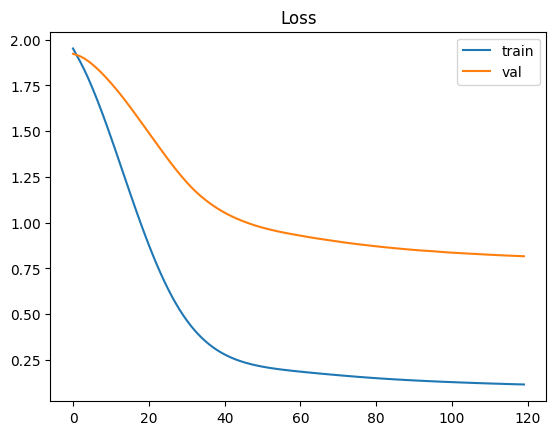

In [73]:
n_epochs = 120
for i in trange(n_epochs):

    logits = model(graph, feat)
    train_loss = F.cross_entropy(logits[train_mask], label[train_mask])

    opt.zero_grad()
    train_loss.backward()
    opt.step()

    with torch.no_grad():
        val_loss = F.cross_entropy(logits[val_mask], label[val_mask])

    log.append([train_loss.item(), val_loss.item()])

plt.plot(np.array(log))
plt.title('Loss')
plt.legend(['train', 'val'])
plt.show()

In [74]:
with torch.no_grad():
    logits = model(graph, feat)
y_pred = torch.argmax(logits[test_mask], 1)
score = balanced_accuracy_score(label[test_mask], y_pred)
assert score > 0.7
print(f'Balanced accuracy: {score:.2f}')

Balanced accuracy: 0.81


We can explain model's predictions using GAT — neighbors with large attention score have the great impact to model's prediction. Let us calculate the neighbors importance using the attention score.

Write a function `neighbor_importance` that takes a node index for which we want to explain the prediction, a trained GAT, a graph and a feature matrix. It returns a tuple:
* np.array with indices of neighbors
* np.array with attention scores on the first GAT layer for each neighbor. Attention score is averaged among all heads.

_Hint: use `graph.predecessors` to obtain neighbors_

In [106]:
def neighbor_importance(expl_node, model, graph, feat):

    with torch.no_grad(), graph.local_scope():
        graph = graph.add_self_loop()
        # YOUR CODE HERE

        neigh_idx = np.array(graph.predecessors(expl_node))
        neigh_att = np.array(model.conv1(graph, feat)[neigh_idx]).mean(axis=1)

        return neigh_idx, neigh_att

In [107]:
neigh, attn = neighbor_importance(1941, model, graph, feat)
assert type(neigh) == type(attn) == np.ndarray
assert (neigh.shape == attn.shape == (7, )) or (neigh.shape == attn.shape == (6, ))
assert round(attn.sum(), 2) == 1

plt.bar(neigh.astype('str'), attn)
plt.xlabel('Node')
plt.ylabel('Attention')
plt.title('Neighbor importance')
plt.show()

AssertionError: 

In [108]:
round(attn.sum(), 2)

np.float32(0.97)